In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



SARIMAX for Luzon
DATA PREPROCESSING

In [2]:
labels_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_labels_transformed.csv'
data_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_data_transformed.csv'
test_data_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_data.csv'
test_labels_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_labels.csv'
transformed_data=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/data_transformed.csv'
transformed_test=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_data_transformed.csv'
complete_data = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/LUZ_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)
transformed_test_data = pd.read_csv(transformed_test)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [3]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [4]:
#Preparing the dataframes
#Rename columns of complete transformed test dataframe
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)
transformed_train_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
data_columns = ['FLOW_LUZ', 'Hourly Demand', 'TMAX_Cubi Point', 'TMAX_NAIA', 'TMIN_NAIA', 'TMAX_Science Garden', 'TMAX_SanJose', 'TMIN_SanJose', 'TMAX_Tayabas', 'TMIN_Tayabas', 'TMAX_CLSU', 'TMIN_CLSU', 'TMAX_Ambulong', 'TMAX_Casiguran', 'TMIN_Casiguran', 'TMAX_Clark', 'TMIN_Clark', 'TMAX_Calapan', 'TMIN_Calapan', 'GWAP', 'LWAP', 'TMIN_Cubi Point', 'TMIN_Science Garden', 'TMIN_Ambulong', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Cubi Point', 'RAINFALL_NAIA', 'RAINFALL_Science Garden', 'RAINFALL_San Jose', 'RAINFALL_Tayabas', 'RAINFALL_CLSU', 'RAINFALL_Tanay', 'TMAX_Tanay', 'TMIN_Tanay', 'RAINFALL_Ambulong', 'RAINFALL_Casiguran', 'RAINFALL_Clark', 'RAINFALL_Calapan']

#Rename columns of complete transformed dataframe
transformed_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)

#Extracting transformed test data
transformed_test_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
transformed_labels_test = pd.DataFrame(transformed_test_data, columns = labels_columns)

data_train = pd.DataFrame(transformed_train_data)
data_test = pd.DataFrame(test_data, columns = data_columns)


In [5]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])



Multicollinearity Test

In [6]:
#Iteratively checking multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'exog_data' contains your exogenous variables
X = transformed_exog.copy()
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)



                    feature         VIF
0                  FLOW_LUZ    9.367419
1             Hourly Demand   46.953346
2           TMAX_Cubi Point   45.831293
3                 TMAX_NAIA   79.425110
4                 TMIN_NAIA   55.678146
5       TMAX_Science Garden   65.219018
6              TMAX_SanJose   33.988524
7              TMIN_SanJose   23.811846
8              TMAX_Tayabas   60.222969
9              TMIN_Tayabas   25.059688
10                TMAX_CLSU   61.292667
11                TMIN_CLSU   51.146850
12            TMAX_Ambulong   55.790642
13           TMAX_Casiguran   43.909658
14           TMIN_Casiguran   55.778278
15               TMAX_Clark   86.852346
16               TMIN_Clark   64.248056
17             TMAX_Calapan   58.497182
18             TMIN_Calapan   36.180539
19          TMIN_Cubi Point   38.226231
20      TMIN_Science Garden   37.751900
21            TMIN_Ambulong   32.515171
22          RESERVE_GWAP_Fr   10.504058
23          RESERVE_GWAP_Ru   15.105796


In [7]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Check and remove high VIF variables iteratively
high_vif_threshold = 10  # Set your threshold here
while True:
    vif_data = calculate_vif(X)
    max_vif = vif_data['VIF'].max()
    
    if max_vif > high_vif_threshold:
        # Find the variable with the highest VIF
        feature_to_drop = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
        print(f"Dropping {feature_to_drop} with VIF of {max_vif}")
        # Drop the variable and recalculate VIF
        X.drop(columns=[feature_to_drop], inplace=True)
    else:
        break

print("Final VIF values:\n", calculate_vif(X))
display(X)

Dropping RAINFALL_Tanay with VIF of 174.08283255131474
Dropping TMAX_Tanay with VIF of 132.1223694762746
Dropping TMIN_Tanay with VIF of 99.23732063588601
Dropping TMAX_Clark with VIF of 84.93049926613556
Dropping TMAX_NAIA with VIF of 77.67905021924017
Dropping TMIN_Clark with VIF of 61.97891534839404
Dropping TMAX_Tayabas with VIF of 59.167132687050795
Dropping TMIN_Casiguran with VIF of 53.81803211856434
Dropping TMAX_Calapan with VIF of 51.99886277051117
Dropping TMIN_NAIA with VIF of 51.021090827018966
Dropping TMAX_CLSU with VIF of 48.76748098992788
Dropping TMAX_Science Garden with VIF of 43.29783810374063
Dropping Hourly Demand with VIF of 40.62539496213083
Dropping TMIN_CLSU with VIF of 40.05023504345063
Dropping TMIN_Cubi Point with VIF of 32.88546370195628
Dropping TMIN_Calapan with VIF of 31.1056384380771
Dropping TMAX_Ambulong with VIF of 29.991306627331998
Dropping TMAX_SanJose with VIF of 28.146558863701543
Dropping TMIN_Ambulong with VIF of 27.377264445588384
Dropping R

,FLOW_LUZ,TMAX_Cubi Point,TMIN_Science Garden,RESERVE_GWAP_Fr,RESERVE_GWAP_Rd,RESERVE_GWAP_Dr,RAINFALL_Science Garden,RAINFALL_San Jose,RAINFALL_Tayabas,RAINFALL_Casiguran,RAINFALL_Clark
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.699592,0.279279,0.216416,0.413701,0.566272,0.000000,0.326277,0.000000,0.449004,0.539452,0.40351
2,0.699592,0.342342,0.119489,0.485412,0.562498,0.000014,0.326277,0.407887,0.531134,0.394799,0.40351
3,0.699313,0.378378,0.147265,0.545262,0.639272,0.094479,0.326277,0.407887,0.000000,0.394799,0.40351
4,0.698963,0.414414,0.200221,0.511919,0.622942,0.133361,0.326277,0.407887,0.288437,0.700535,0.40351
...,...,...,...,...,...,...,...,...,...,...,...
725,0.491802,0.576577,0.277040,0.272389,0.040335,0.450013,0.428489,0.407887,0.707838,0.954932,0.40351
726,0.544347,0.666667,0.418198,0.585957,0.302347,0.456554,0.362478,0.407887,0.692619,0.920120,0.40351
727,0.579528,0.612613,0.314562,0.568888,0.396312,0.083561,0.326277,0.407887,0.678458,0.539452,0.40351
728,0.736436,0.666667,0.286219,0.200984,0.364476,0.377857,0.000000,0.407887,0.449004,0.893401,0.40351


In [8]:
#Preparing the exog datasets
train_exog = X[:train_size]
test_exog = X[train_size:]


In [9]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = transformed_labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]


#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = transformed_labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [11]:
#Applying the inverse transformations
#Loading inverse transformations for Luzon

minmax_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeliney.pkl')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\A

In [12]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Luzon GWAP")
lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [13]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [14]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Date
2022-01-01    0.258105
2022-01-02    0.314556
2022-01-03    0.418724
2022-01-04    0.501099
2022-01-05    0.787813
                ...   
2023-08-03    0.317026
2023-08-04    0.432209
2023-08-05    0.410919
2023-08-06    0.415499
2023-08-07    0.426566
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [15]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'TMAX_Cubi Point' is stationary after differencing 0 times.
Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 0 times.
Column 'RAINFALL_San Jose' is stationary after differencing 0 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [16]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 1 times.
Column 'RAINFALL_San Jose' is stationary after differencing 1 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 1 times.
Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 1 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_17988\24

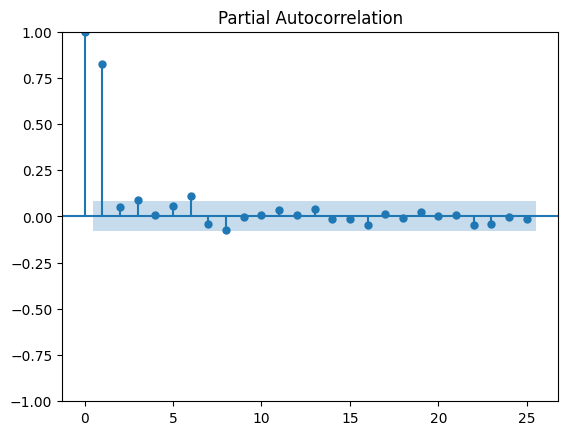

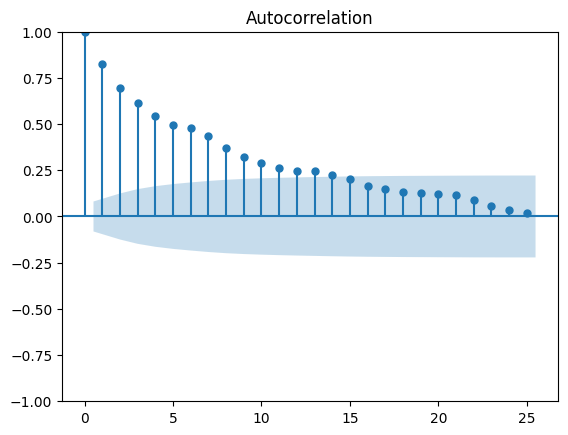

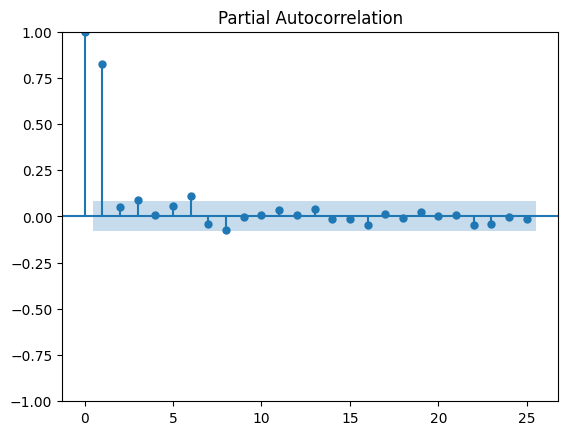

In [16]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

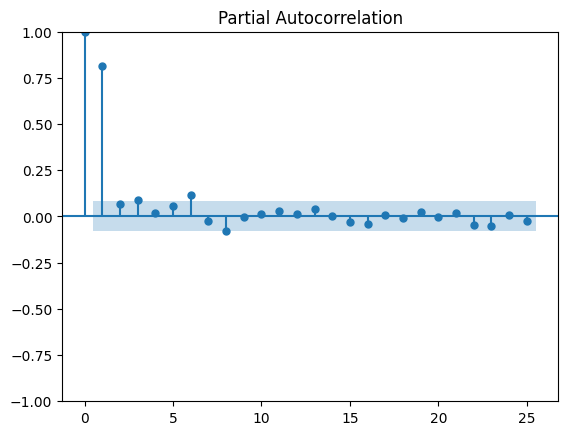

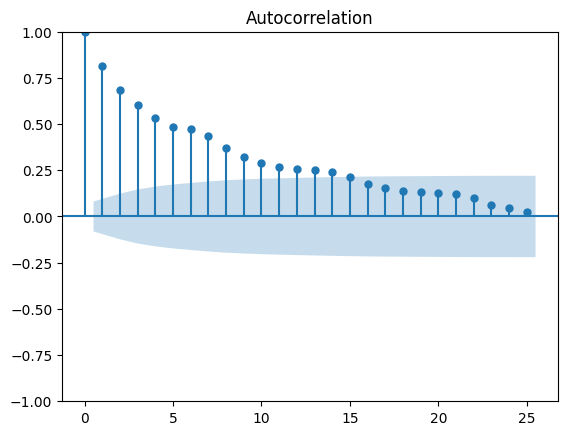

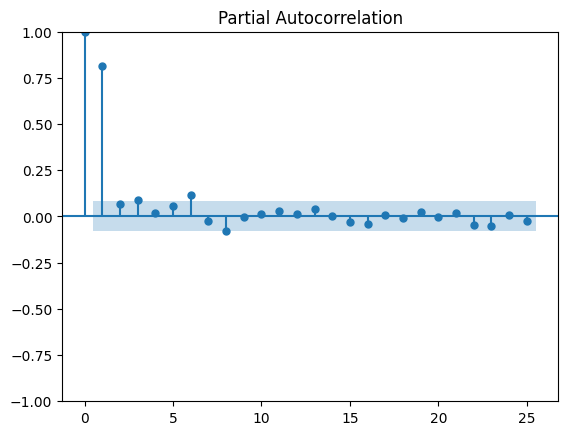

In [17]:
#LUZON LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [31]:
def seasonal_auto_arima(df, max_p, max_d, max_q, exog_data=None):
    lowest_aic = float("inf")
    best_model = None
    
    # Sequence of seasonal periods to try
    seq = [1,2,3,4,5,6,7,14,30]
    for i in seq:
        try:
            model = auto_arima(df, 
                               start_p=0, start_d=0, start_q=0,
                               max_p=max_p, max_d=max_d, max_q=max_q, 
                               seasonal=True, m=i, 
                               start_P=0, start_D=0, start_Q=0,
                               error_action='warn', trace=False,
                               suppress_warnings=True, stepwise=False,
                               exog=exog_data, 
                               maxiter=300, method='powell')
            
            if model.aic() < lowest_aic:
                lowest_aic = model.aic()
                best_model = model

        except Exception as e:
            print(f"Model fitting failed for seasonality {i}: {e}")

    try:
        model = auto_arima(df, 
                           start_p=0, start_d=0, start_q=0,
                           max_p=max_p, max_d=max_d, max_q=max_q, 
                           seasonal=False,
                           error_action='warn', trace=False,
                           suppress_warnings=True, stepwise=False,
                           exog=exog_data, 
                           maxiter=300, method='powell')
        
        if model.aic() < lowest_aic:
            lowest_aic = model.aic()
            best_model = model

    except Exception as e:
        print(f"Non-seasonal model fitting failed: {e}")

    if best_model is not None:
        if best_model.seasonal_order == (0, 0, 0, 0):
            print(f"The model with the lowest AIC is non-seasonal with an AIC of {lowest_aic}")
        else:
            print(f"The model with the lowest AIC has a seasonal period of {best_model.seasonal_order[3]} and an AIC of {lowest_aic}")
    else:
        print("No suitable model found.")
        
    return best_model

# Example usage
# data = pd.read_csv('your_time_series_data.csv', parse_dates=True, index_col='Date')
# exog_data = pd.read_csv('your_exogenous_data.csv', parse_dates=True, index_col='Date')
# best_model = seasonal_auto_arima('your_target_column', data, max_p=5, max_d=2, max_q=5, exog_data=exog_data)


In [32]:
GWAP_sarimax = seasonal_auto_arima(GWAP_train, max_p=1, max_d=2, max_q=13, exog_data=diff_exog_train )

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 6 and an AIC of -1070.7818288347298


In [33]:
GWAP_sarimax

ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 6), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.954305
         Iterations: 8
         Function evaluations: 1136


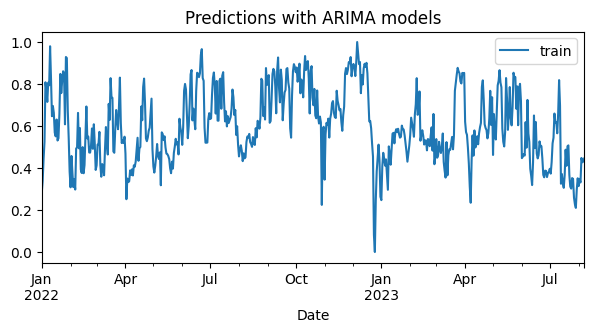

In [17]:
#Using statsmodels

gwap_model = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(0,0,1,6))
gwap_model_results=gwap_model.fit(method='powell', maxiter=300)

gwap_train_predict = gwap_model_results.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with SARIMAX models')
ax.legend()

In [23]:
gwap_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              GWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 6)   Log Likelihood                 557.314
Date:                           Wed, 29 Jan 2025   AIC                          -1084.629
Time:                                   10:25:51   BIC                          -1019.106
Sample:                               01-01-2022   HQIC                         -1059.089
                                    - 08-07-2023                                         
Covariance Type:                             opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                    0.0185      0.029      0.629      0.529      -0.039       0.076
TMAX_Cubi Point             0.0662      0.037      1.802      0.072      -0.006       0.138
TMIN_Science Garden         0.0370      0.024      1.566      0.117      -0.009       0.083
RESERVE_GWAP_Fr            -0.0225      0.026     -0.873      0.383      -0.073       0.028
RESERVE_GWAP_Rd            -0.0823      0.040     -2.058      0.040      -0.161      -0.004
RESERVE_GWAP_Dr            -0.0022      0.010     -0.223      0.823      -0.021       0.017
RAINFALL_Science Garden    -0.0206      0.016     -1.251      0.211      -0.053       0.012
RAINFALL_San Jose          -0.0101      0.019     -0.540      0.589      -0.047       0.027
RAINFALL_Tayabas           -0.0207      0.015     -1.428      0.153      -0.049       0.008
RAINFALL_Casiguran         -0.0361      0.012     -2.911      0.004      -0.060      -0.012
RAINFALL_Clark             -0.0166      0.014     -1.199      0.231      -0.044       0.011
ar.L1                       0.7867      0.031     25.686      0.000       0.727       0.847
ma.L1                      -0.9769      0.014    -71.201      0.000      -1.004      -0.950
ma.S.L6                     0.1234      0.048      2.579      0.010       0.030       0.217
sigma2                      0.0087      0.000     20.001      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                29.69
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.08
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

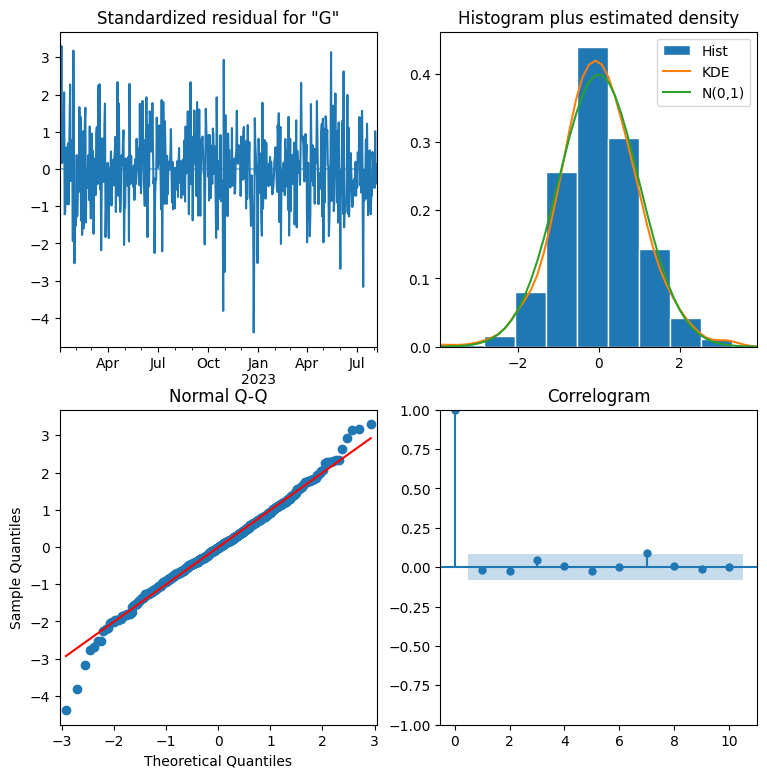

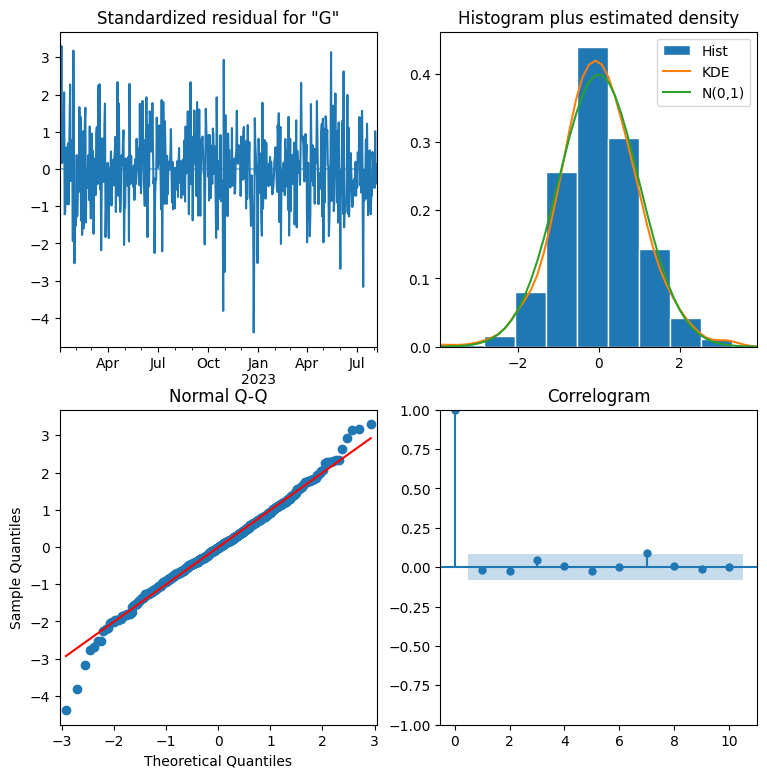

In [24]:
gwap_model_results.plot_diagnostics(figsize=(9,9))


,GWAP,LWAP
0,0.278764,0.258105
1,0.337307,0.314556
2,0.443016,0.418724
3,0.525069,0.501099
4,0.808333,0.787813
...,...,...
579,0.331255,0.317026
580,0.447944,0.432209
581,0.427384,0.410919
582,0.431395,0.415499


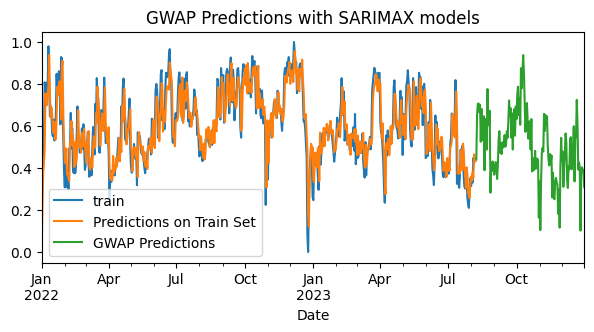

In [25]:

#Append model results to original data
appended_gwap = gwap_model_results.append(GWAP_test, exog=diff_exog_test, refit=False)

#Forecast day-ahead
gwap_test_predict = appended_gwap.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=False)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('GWAP Predictions with SARIMAX models')
ax.legend()

In [34]:
LWAP_sarimax = seasonal_auto_arima(LWAP_train, max_p=1, max_d=2, max_q=14, exog_data=diff_exog_train )

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

The model with the lowest AIC has a seasonal period of 7 and an AIC of -1030.783266941296


In [35]:
LWAP_sarimax

ARIMA(maxiter=300, method='powell', order=(1, 1, 1), scoring_args={},
      seasonal_order=(1, 0, 0, 7), suppress_warnings=True)

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.921779
         Iterations: 8
         Function evaluations: 1129


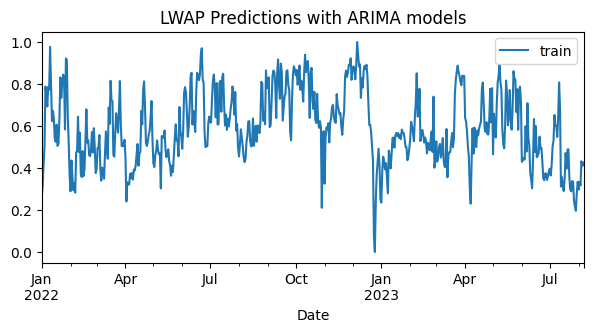

In [24]:

lwap_model = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,0,7))
lwap_model_results=lwap_model.fit(method='powell', maxiter=300)
#Check fit on train set
lwap_train_predict = lwap_model_results.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
ax.set_title('LWAP Predictions with SARIMAX models')
ax.legend()

In [27]:
lwap_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               LWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 538.319
Date:                            Wed, 29 Jan 2025   AIC                          -1046.638
Time:                                    11:02:05   BIC                           -981.116
Sample:                                01-01-2022   HQIC                         -1021.099
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                    0.0219      0.032      0.675      0.499      -0.042       0.085
TMAX_Cubi Point             0.0692      0.038      1.844      0.065      -0.004       0.143
TMIN_Science Garden         0.0503      0.023      2.157      0.031       0.005       0.096
RESERVE_GWAP_Fr            -0.0424      0.026     -1.611      0.107      -0.094       0.009
RESERVE_GWAP_Rd            -0.0932      0.039     -2.410      0.016      -0.169      -0.017
RESERVE_GWAP_Dr          7.702e-05      0.010      0.008      0.994      -0.019       0.019
RAINFALL_Science Garden    -0.0210      0.017     -1.228      0.220      -0.055       0.013
RAINFALL_San Jose          -0.0121      0.019     -0.655      0.512      -0.048       0.024
RAINFALL_Tayabas           -0.0217      0.015     -1.476      0.140      -0.050       0.007
RAINFALL_Casiguran         -0.0355      0.013     -2.752      0.006      -0.061      -0.010
RAINFALL_Clark             -0.0091      0.014     -0.667      0.505      -0.036       0.018
ar.L1                       0.7846      0.030     26.549      0.000       0.727       0.843
ma.L1                      -0.9767      0.014    -72.025      0.000      -1.003      -0.950
ar.S.L7                     0.1004      0.042      2.384      0.017       0.018       0.183
sigma2                      0.0092      0.000     19.522      0.000       0.008       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                19.25
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.06
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

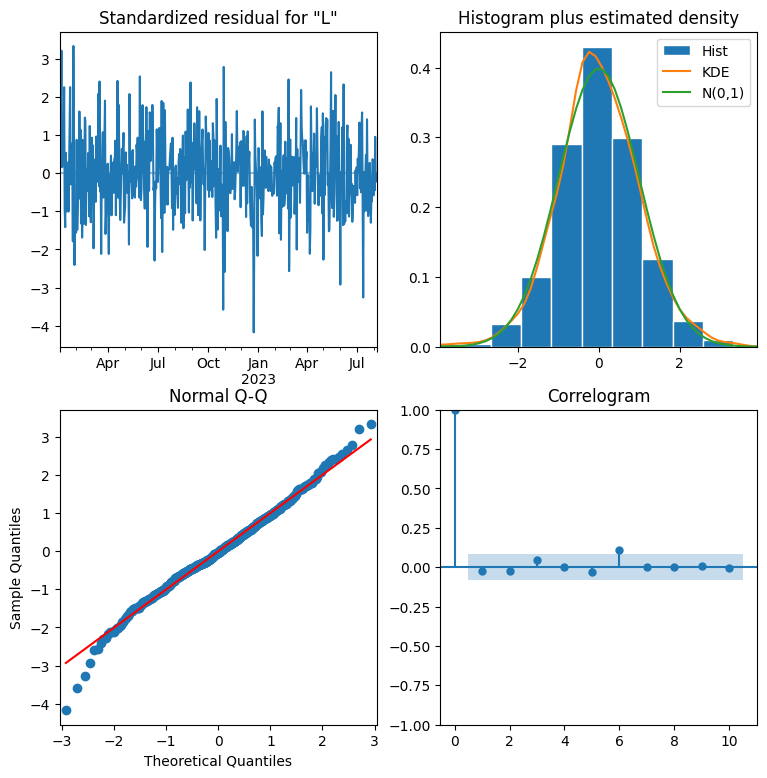

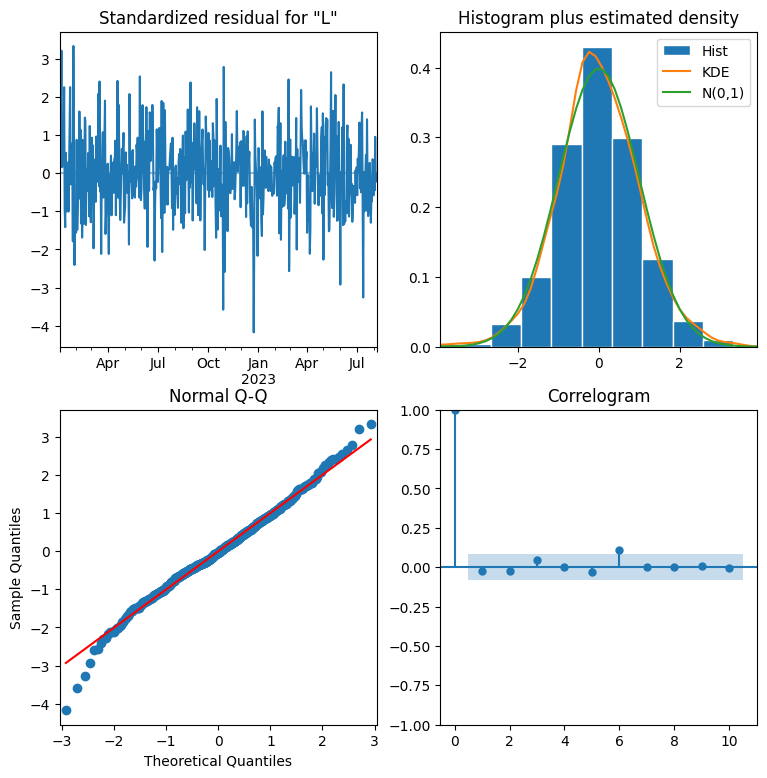

In [28]:
lwap_model_results.plot_diagnostics(figsize=(9,9))

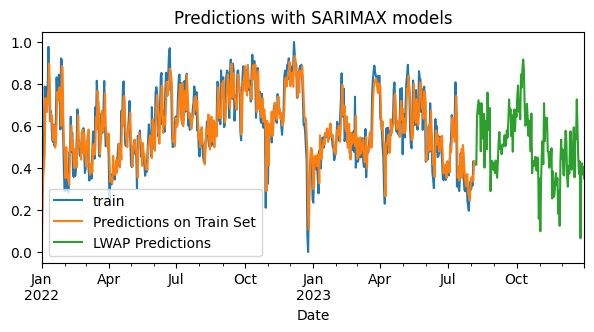

In [36]:
#Append model results to original data
appended_lwap = lwap_model_results.append(LWAP_test, exog=diff_exog_test, refit=False)

#Forecast day-ahead
lwap_test_predict = appended_lwap.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=False)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with SARIMAX models')
ax.legend()

Applying inverse transformations - non-rolling

In [30]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[ 4828.98301095,  4962.34820634],
       [ 9473.5064198 , 10701.86322152],
       [11678.22104336, 12178.12765108],
       [11768.94417243, 14183.43338363],
       [10038.90389376, 10931.504407  ],
       [11507.67914551, 13334.79975526],
       [ 6181.66345447,  5974.60003884],
       [10615.27957483, 13355.9703086 ],
       [ 8397.48426556,  9222.3751215 ],
       [ 6324.36871433,  7204.9385842 ],
       [ 9311.53009891, 10982.65616972],
       [ 4193.00945866,  4751.50199683],
       [ 8889.95414143,  8835.57313958],
       [ 7391.23644618,  9756.90715496],
       [ 5533.90192676,  6138.92505   ],
       [15789.10792605, 16556.28998652],
       [ 8143.63159712, 10195.75898301],
       [ 7975.4000064 ,  8285.48945301],
       [10291.83690578, 12242.03322038],
       [ 3203.95518269,  3511.25601097],
       [ 4582.26531535,  4691.24407284],
       [ 4162.62994116,  5210.40010879],
       [ 4694.68804041,  5011.37387132],
       [ 4314.72104676,  4619.60272645],
       [ 3969.41

In [31]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

In [32]:
# Calculate MAE for the Luzon GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon GWAP test set
mse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 2173.774951596343
Root Mean Squared Error (RMSE) on Test Set: 3524.048397805398


Mean Absolute Error (MAE) on Test Set: 2657.9971939131474
Root Mean Squared Error (RMSE) on Test Set: 3996.2742789107606


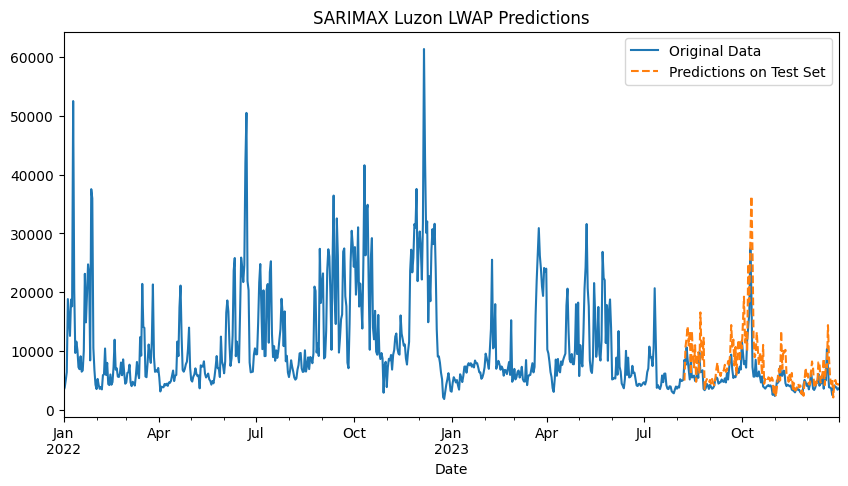

In [33]:
# Calculate MAE for the Luzon LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon LWAP test set
mse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon LWAP Predictions')
ax.legend()
plt.show()

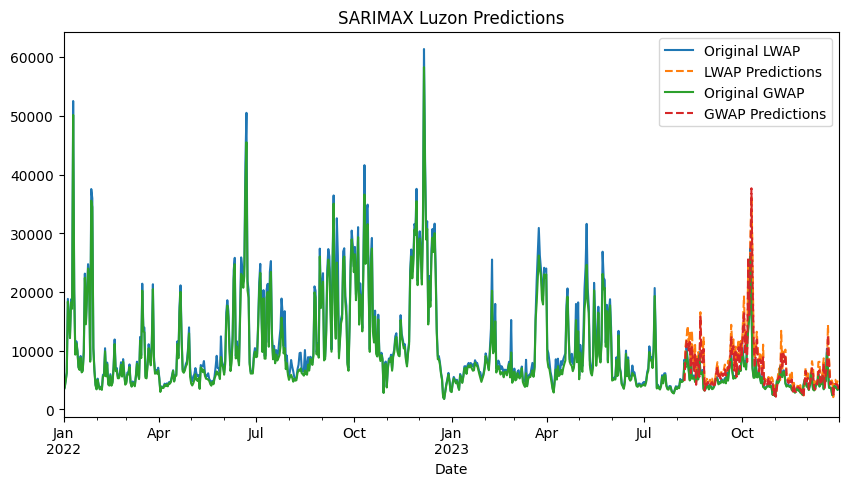

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Luzon Predictions')
ax.legend()
plt.show()

In [49]:
GWAP_predictions_inverse.to_csv('luz-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('luz-lwap-predictions.csv', index=False)